In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
# from skimage import color
# from skimage import io
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import h5py
%matplotlib inline

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 显示中文

In [7]:
mat = loadmat('./data/train_32x32.mat')
X = mat['X'] # (32, 32, 3, 73257)
Y = mat['y'] # (73257, 1)
n=X.shape[-1]

print(X.shape)

mat = loadmat('./data/test_32x32.mat')
X_test = mat['X']
Y_test = mat['y']
n_test=X_test.shape[-1]
print(X_test.shape)
print(np.unique(Y))
print(np.unique(Y_test))

(32, 32, 3, 73257)
(32, 32, 3, 26032)
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]


In [8]:
# 把最后一维移到第一维
print(X.shape)
X, Y = X.transpose((3,0,1,2)), Y[:,0]
print(X.shape)
X_test, Y_test = X_test.transpose((3,0,1,2)), Y_test[:,0]

(32, 32, 3, 73257)
(73257, 32, 32, 3)


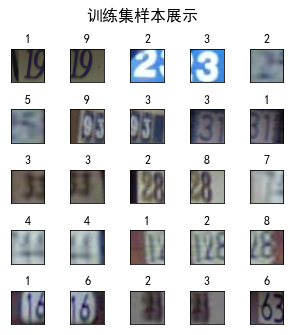

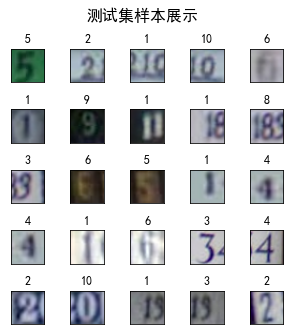

In [11]:
plt.rcParams['figure.figsize'] = (5,6) # 调整展示时的图片区域大小
# 随机选择一些图片进行展示，上方的数字是标签/类名
def plot_images(img, labels, r, c,name):
    randIndices=[np.random.randint(0,img.shape[0]) for i in range(r*c)]
    fig, axes = plt.subplots(r, c)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i],cmap="gray")
        else:
            ax.imshow(img[i,:,:,0],cmap="gray")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])
    plt.suptitle(name, fontsize=16, ha='center')
    plt.gcf().set_size_inches(450 / 100, 450 / 100)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=0.85, bottom=0, right=0.95, left=0.08, hspace=0.8, wspace=0.4)
    plt.margins(0, 0)

    
plot_images(X, Y, 5, 5,"训练集样本展示")
plt.savefig('out/train.png')
plot_images(X_test, Y_test, 5, 5,"测试集样本展示")
plt.savefig('out/test.png')

训练集中每个类的占比
[0.189, 0.144, 0.116, 0.102, 0.094, 0.078, 0.076, 0.069, 0.064, 0.068]
测试集中每个类的占比
[0.196, 0.159, 0.111, 0.097, 0.092, 0.076, 0.078, 0.064, 0.061, 0.067]


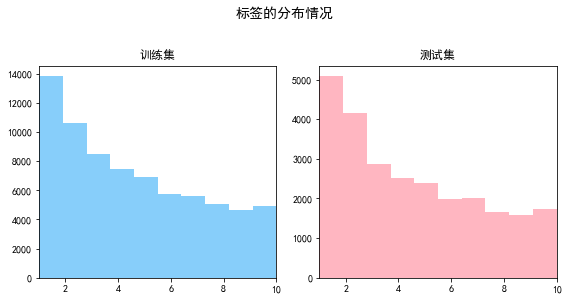

In [12]:
plt.rcParams['figure.figsize'] = (8,4) # 调整展示时的图片区域大小
# 查看类的分布情况
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('标签的分布情况', fontsize=14, fontweight='bold', y=1.03)

ax1.hist(Y, color='#87CEFA',bins=10)
ax1.set_title("训练集")
ax1.set_xlim(1, 10)

ax2.hist(Y_test, color='#FFB6C1', bins=10)
ax2.set_title("测试集")
# ax2.set_xlim(1, 10)
fig.tight_layout()

def print_distribution(y):
    d=[]
    for i in range(1,11):
        d.append(round(np.sum(y==i)/y.shape[0],3))
    print(d)

print('训练集中每个类的占比')
print_distribution(Y)
print('测试集中每个类的占比')
print_distribution(Y_test)

In [19]:
# 取小样本数据集
n=1000
randIndices=[np.random.randint(0,X.shape[0]) for i in range(n)]
X = X[randIndices]
Y = Y[randIndices]
# X=X/255
# X=(X/255-0.5)*2
# X = np.column_stack((np.full((n,1),1),X)) #  hstack

n_test=100
randIndices=[np.random.randint(0,X_test.shape[0]) for i in range(n_test)]
X_test = X_test[randIndices]
Y_test = Y_test[randIndices]
# X_test=X_test/255
# X_test=(X_test/255-0.5)*2
# X_test = np.column_stack((np.full((n_test,1),1),X_test))

In [13]:
# 类10转0
Y[Y == 10] = 0
Y_test[Y_test == 10] = 0
print(np.unique(Y_test))

[0 1 2 3 4 5 6 7 8 9]


In [10]:
# 灰度转换
plt.rcParams['figure.figsize'] = (5,6) # 调整展示时的图片区域大小
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)
print("Training Set", X.shape)
print("Test Set", X_test.shape)
X = rgb2gray(X).astype(np.float32)
X_test = rgb2gray(X_test).astype(np.float32)
print("Training Set", X.shape)
print("Test Set", X_test.shape)
plot_images(X/255, Y, 5, 5,"灰度转换后的图")
plt.savefig('out/gray_train.png')
plot_images(X_test, Y_test, 5, 5,"灰度转换后的测试集样本")
plt.savefig('out/gray_test.png')

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)
Training Set (73257, 32, 32, 1)
Test Set (26032, 32, 32, 1)


NameError: name 'plot_images' is not defined

In [15]:
# Normalization(可用于实验)
X_mean = np.mean(X, axis=0) # 第一维变化，对其他维每个位置上求均值和方差
X_std = np.std(X, axis=0)

# Subtract it equally from all splits
X = (X - X_mean) / X_std
X_test = (X_test - X_mean)  / X_std

In [18]:
encoder = OneHotEncoder().fit(Y.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
Y = encoder.transform(Y.reshape(-1, 1)).toarray()
encoder = OneHotEncoder().fit(Y_test.reshape(-1, 1))
Y_test = encoder.transform(Y_test.reshape(-1, 1)).toarray()

print("训练集", Y.shape)
print("测试集", Y_test.shape)

训练集 (732570, 2)
测试集 (26032, 10)


In [20]:
# 存储预处理后的数据集
h5f = h5py.File('data/SVHN_1000_100_g_n_e.h5', 'w')

# Store the datasets
h5f.create_dataset('X_1000_g_n', data=X) # gray normalization
h5f.create_dataset('Y_1000_e', data=Y) # encoder
h5f.create_dataset('X_test_100_g_n', data=X_test)
h5f.create_dataset('Y_test_100_e', data=Y_test)

# Close the file
h5f.close()

In [10]:
# pca
# coding: utf-8
import scipy.io as io
from scipy import optimize
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
plt.gray();
import matplotlib.patheffects as pe
import seaborn as sb
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
%matplotlib inline
# from IPython.display import display
infinity = float(-2**31)
# np.set_printoptions(suppress=True, threshold=np.nan)    #去除科学计数法
pca = PCA(n_components=0.9)

def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

mat = io.loadmat('./data/train_32x32.mat')
X = mat['X'] # (32, 32, 3, 73257)
Y = mat['y'] # (73257, 1)
Y[Y == 10] = 0
X = X.transpose((3, 0, 1, 2))
X=X[0:888]
Y=Y[0:888]
print(X.shape)
X = rgb2gray(X).astype(np.float32)
print(X.shape)
X=X.reshape(X.shape[0],-1)#.transpose()  # (73257,3072)
X_mean = np.mean(X, axis=0)  # 第一维变化，对其他维每个位置上求均值和方差
X_std = np.std(X, axis=0)
X = (X - X_mean) / X_std
print(X.shape) 
pca.fit(X)                  #训练
X=pca.fit_transform(X)   #降维后的数据
print(pca.explained_variance_ratio_)  #输出贡献率
print(X.shape)                  #输出降维后的数据


mat = io.loadmat('./data/test_32x32.mat')
X_test = mat['X']
Y_test = mat['y']
print(X_test.shape)
print(Y_test.shape)
Y_test[Y_test == 10] = 0
X_test = X_test.transpose((3, 0, 1, 2))
X_test = rgb2gray(X_test).astype(np.float32)
X_test=X_test.reshape(-1,n_test).transpose()
X_test = (X_test - X_mean) / X_std


# print(X.shape,Y.shape,X_test.shape,Y_test.shape)

(32, 32, 3, 26032)
(26032, 1)
